In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
geolocation = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
category = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')

In [4]:
print('Customers:', customers.shape)
print('Reviews:', reviews.shape)
print('Sellers:', sellers.shape)
print('Orders:', orders.shape)
print('Order Items:', order_items.shape)
print('Products:', products.shape)
print('Payments:', payments.shape)
print('Geolocation:', geolocation.shape)

Customers: (99441, 5)
Reviews: (99224, 7)
Sellers: (3095, 4)
Orders: (99441, 8)
Order Items: (112650, 7)
Products: (32951, 9)
Payments: (103886, 5)
Geolocation: (1000163, 5)


In [5]:
for df, name in zip([orders, order_items, customers, products, payments, reviews, sellers, geolocation],
                    ['orders', 'order_items', 'customers', 'products', 'payments', 'reviews', 'sellers', 'geolocation']):
    print(f"Missing values in {name}:\n", df.isnull().sum(), "\n")

date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')
orders_items = pd.merge(orders, order_items, on='order_id', how='inner')

orders_items_products = pd.merge(orders_items, products, on='product_id', how='left')

full_data = pd.merge(orders_items_products, customers, on='customer_id', how='left')
print('Merged dataset shape:', full_data.shape)

Missing values in orders:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64 

Missing values in order_items:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64 

Missing values in customers:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64 

Missing values in products:
 product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
prod

In [6]:
products['product_category_name'] = products['product_category_name'].fillna('unknown')

num_cols = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty',
            'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

for col in num_cols:
    median_val = products[col].median()
    products[col] = products[col].fillna(median_val)

In [7]:
orders_items_products = pd.merge(orders_items, products, on='product_id', how='left')
full_data = pd.merge(orders_items_products, customers, on='customer_id', how='left')
print('Updated merged dataset shape:', full_data.shape)

Updated merged dataset shape: (112650, 26)


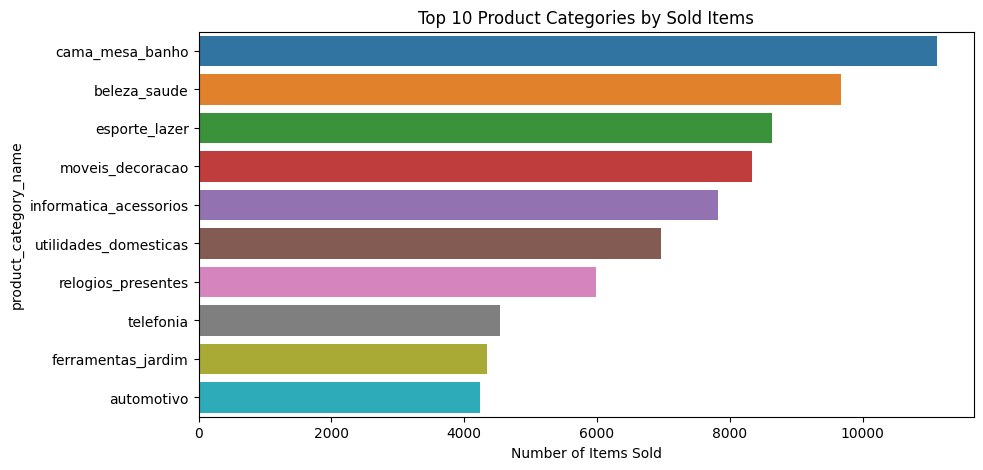

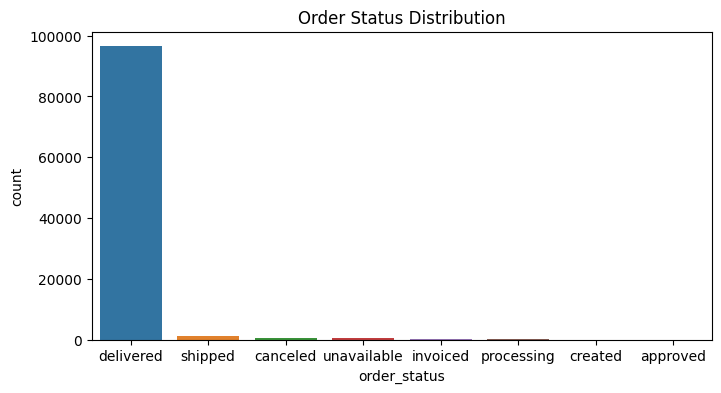

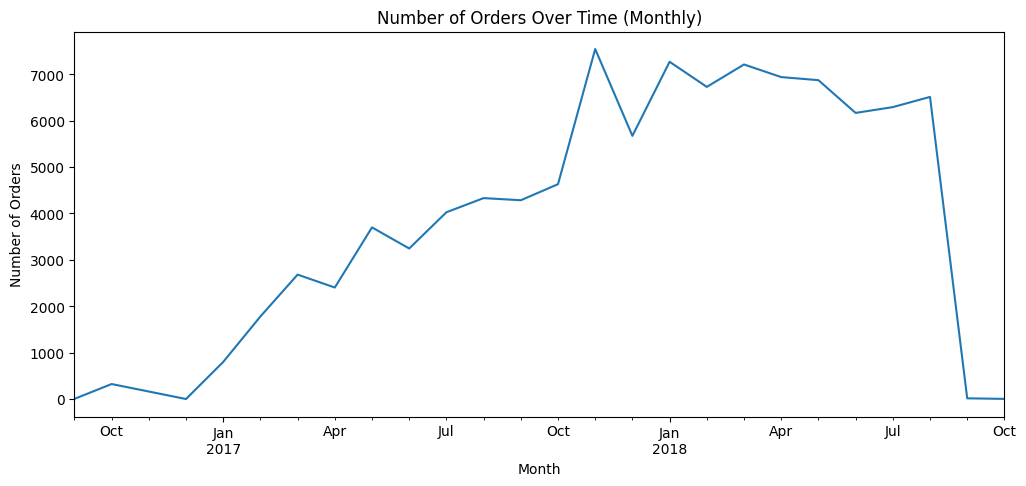

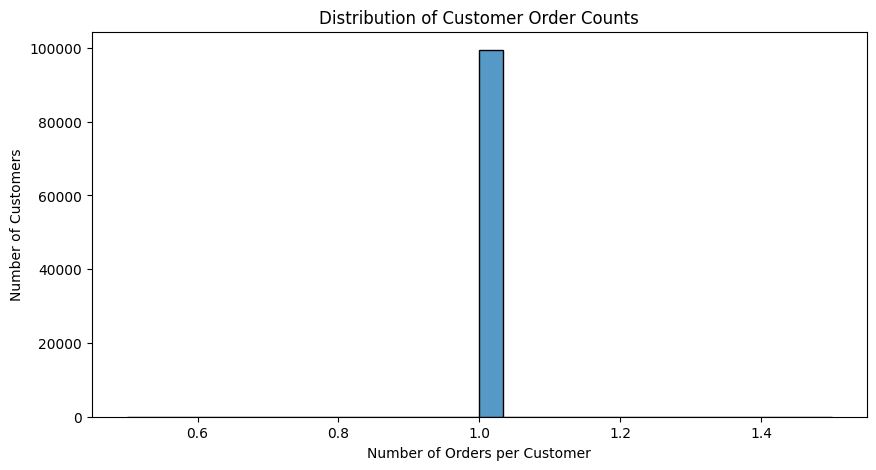

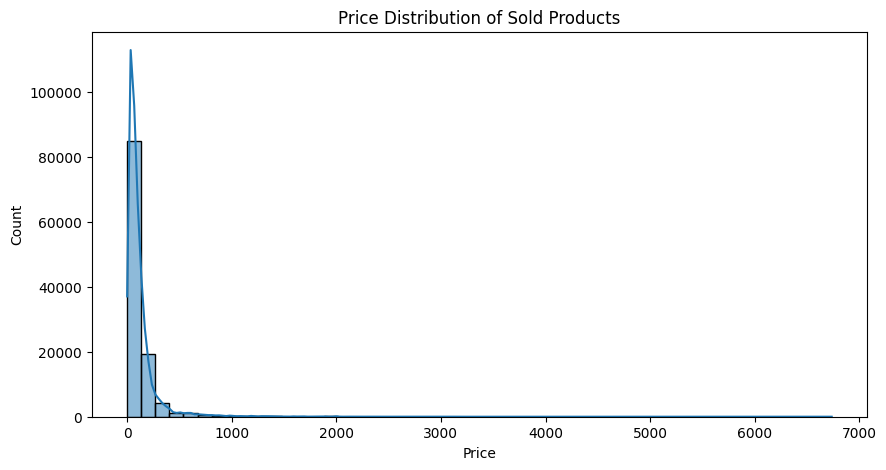

In [8]:
top_categories = full_data['product_category_name'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories by Sold Items')
plt.xlabel('Number of Items Sold')
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=orders, x='order_status', order=orders['order_status'].value_counts().index)
plt.title('Order Status Distribution')
plt.show()

orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
orders_by_month = orders['order_purchase_month'].value_counts().sort_index()
plt.figure(figsize=(12,5))
orders_by_month.plot(kind='line')
plt.title('Number of Orders Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

cust_order_counts = orders['customer_id'].value_counts()
plt.figure(figsize=(10,5))
sns.histplot(cust_order_counts, bins=30, kde=False)
plt.title('Distribution of Customer Order Counts')
plt.xlabel('Number of Orders per Customer')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(full_data['price'], bins=50, kde=True)
plt.title('Price Distribution of Sold Products')
plt.xlabel('Price')
plt.show()

In [9]:
interaction_df = full_data.groupby(['customer_id', 'product_id']).size().unstack(fill_value=0)
print('User-Product interaction matrix shape:', interaction_df.shape)

User-Product interaction matrix shape: (98666, 32951)


In [10]:
top_products = full_data['product_id'].value_counts().head(1000).index
interaction_small = interaction_df[top_products]
print('Reduced interaction matrix shape:', interaction_small.shape)
product_similarity_small = cosine_similarity(interaction_small.T)
product_similarity_df_small = pd.DataFrame(product_similarity_small, index=interaction_small.columns, columns=interaction_small.columns)

Reduced interaction matrix shape: (98666, 1000)


In [11]:
def get_similar_products(product_id, top_n=5):
    if product_id not in product_similarity_df_small.index:
        return []
    sim_scores = product_similarity_df_small[product_id].sort_values(ascending=False)
    sim_scores = sim_scores.drop(product_id)
    return sim_scores.head(top_n).index.tolist()

sample_product = interaction_small.columns[0]
print(f"Top 5 products similar to {sample_product}:")
print(get_similar_products(sample_product))

Top 5 products similar to aca2eb7d00ea1a7b8ebd4e68314663af:
['28b4eced95a52d9c437a4caf9d311b95', '3c883b9d3fd2d0ce448d4136349dc0a4', '3efd399c5d016b9e6a5ad3196eade44f', '42a2bd596fda1baef5719cb74f73030c', '6e77b89d36e50217e6793780a8ce5c82']


In [12]:
product_popularity = full_data['product_id'].value_counts().reset_index()
product_popularity.columns = ['product_id', 'purchase_count']
product_popularity.to_csv('product_popularity.csv', index=False)

In [13]:
product_similarity_df_small.to_csv('product_similarity.csv')

In [14]:
recommendation_rows = []

for product_id in interaction_small.columns[:100]:  
    similar_products = get_similar_products(product_id)
    while len(similar_products) < 5:
        similar_products.append(None)
    
    recommendation_rows.append({
        'base_product_id': product_id,
        'recommended_product_1': similar_products[0],
        'recommended_product_2': similar_products[1],
        'recommended_product_3': similar_products[2],
        'recommended_product_4': similar_products[3],
        'recommended_product_5': similar_products[4],
    })

In [15]:
recommendations_df = pd.DataFrame(recommendation_rows)

In [16]:
recommendations_df.to_csv("product_recommendations.csv", index=False)